In [214]:
"""
MIT License
Copyright (c) 2016 Francesco Gadaleta 

Permission is hereby granted, free of charge, to any person obtaining a copy 
of this software and associated documentation files (the "Software"), to deal 
in the Software without restriction, including without limitation the rights 
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies 
of the Software, and to permit persons to whom the Software is furnished to do 
so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all 
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR 
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, 
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE 
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

--------------------------------------------------------------------------------------
Note: 
Please build training/testing set before running this script.
Make sure to create the local path that have been hardcoded in the following scripts, 
then execute

    % python make_data_class_0.py
    % python make_data_class_1.py
--------------------------------------------------------------------------------------- 

""" 

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import matplotlib
# Force matplotlib to not use any Xwindows backend.
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.models import model_from_json

import skimage.io as io 

import os 
from os import listdir
from os.path import isfile, join
import utils as ut

import librosa
import librosa.display
import IPython.display
import numpy as np
from skimage.measure import block_reduce
import skimage.io as io

In [40]:
# network configuration
batch_size = 32
# number of epochs
nb_epoch = 5
# number of convolutional filters to use
nb_filters = 32
# number of classes 
nb_classes = 2
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

In [30]:
# the data, shuffled and split between train and test sets
# we save generated images here (make sure there is space)
path_class_0 = '/archive/ahem_data/class_0/'
path_class_1 = '/archive/ahem_data/class_1/'

# load filenames into lists 
class0_files = [f for f in listdir(path_class_0) if isfile(join(path_class_0, f))]
class1_files = [f for f in listdir(path_class_1) if isfile(join(path_class_1, f))]

In [31]:
# prepare training set
X_t = []
Y_t = []

for fn in class0_files[:100]:
    img = io.imread(os.path.join(path_class_0, fn))
    img = img.transpose((2,0,1))
    img = img[:3, :, :]
    X_t.append(img)
    Y_t.append(0)

for fn in class1_files[:100]:
    img = io.imread(os.path.join(path_class_1, fn))
    img = img.transpose((2,0,1))
    img = img[:3, :, :]
    X_t.append(img)
    Y_t.append(1)

X_t = np.asarray(X_t)
X_t = X_t.astype('float32')
X_t /= 255

Y_t = np.asarray(Y_t)
Y_t = np_utils.to_categorical(Y_t, nb_classes)

In [53]:
img_rows, img_cols = X_t.shape[2], X_t.shape[3] 
# input image dimensions
img_channels = 3               # RGB
input_shape = (3, img_rows, img_cols)

In [20]:
## test set
X_test = []
Y_test = [] 

for fn in class0_files[6000:8000]:
    img = io.imread(os.path.join(path_class_0, fn))
    img = img.transpose((2,0,1))
    img = img[:3, :, :]
    X_test.append(img)
    Y_test.append(0)

for fn in class1_files[6000:8000]:
    img = io.imread(os.path.join(path_class_1, fn))
    img = img.transpose((2,0,1))
    img = img[:3, :, :]
    X_test.append(img)
    Y_test.append(1)

X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
X_test = X_test.astype('float32')
X_test /= 255

Y_test = np_utils.to_categorical(Y_test, nb_classes)

In [54]:
def make_model():
    model = Sequential()

    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                            border_mode='valid',
                            input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    
    model.add(Convolution2D(nb_filters, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))


    model.compile(loss='binary_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    return model 

def load_image(filename):
    img = io.imread(filename)
    img = img.transpose((2,0,1))
    img = img[:3, :, :]
    return img

In [56]:
model = make_model()
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [156]:
for e in xrange(3):
    model.fit(X_t, Y_t, 
              #validation_data=(X_test, Y_test), 
              batch_size=batch_size, 
              nb_epoch=1, verbose=1)

Epoch 1/1
152/152 [==============================] - 531s - loss: 0.3419 - acc: 0.8816    
Epoch 1/1
152/152 [==============================] - 531s - loss: 0.3189 - acc: 0.9013    
Epoch 1/1
152/152 [==============================] - 531s - loss: 0.4343 - acc: 0.8158    


## Trying if all this stuff works

In [47]:
predictions = model.predict_classes(X_test)

y = []
for e in Y_test:
    if e[0]> e[1]:
        y.append(0)
    else:
        y.append(1)

print('how many did we guess out of ', Y_test.shape)
np.sum(y == predictions)  

# Predictions on new audio sample 

In [69]:
# the data, shuffled and split between train and test sets
path_newsample = '/archive/ahem_data/new_sample/'
newsample_files = [f for f in listdir(path_newsample) if isfile(join(path_newsample, f))]

In [70]:
# prepare test set as we did for training set
X_test = []

for fn in newsample_files:
    img = io.imread(os.path.join(path_newsample, fn))
    img = img.transpose((2,0,1))
    img = img[:3, :, :]
    X_test.append(img)

X_test = np.asarray(X_test)
X_test = X_test.astype('float32')
X_test /= 255

In [158]:
# grab a large cup of coffee this will take a while  
predictions = model.predict_classes(X_test)

394/394 [==============================] - 407s    


In [159]:
# collect all indices of noisy samples (class 1)
# start position is encoded in filename (a trick to run this in parallel with no sequential order)
noisy_frames = np.where(predictions==1)[0]
noisy_files = [newsample_files[n] for n in noisy_frames]

## Playback and clean new samples

In [179]:
# Load a sound with a lot of "ahem" in it
path = '/archive/ahem_data'
sound_file_paths = [os.path.join(path, "provocation_dirty.wav")]
sound_names = ["dirty"]
raw_sounds = ut.load_sound_files(sound_file_paths)
windowsize = 6000 
# create positive samples
audiosamples = raw_sounds[0]
numsamples = audiosamples.shape[0]

In [180]:
original_audio = audiosamples
clean_audio = audiosamples

In [215]:
# Playback from ipython (cool uh?)
IPython.display.Audio(data=original_audio, rate=44100)

In [183]:
noisy_start = []
for fn in noisy_files:
    noisy_start.append(int(fn.split('_')[2].split('.')[0]))

noisy_start.sort(reverse=True)

In [185]:
clean_audio = audiosamples
prev_idx = 0
for start in xrange(1, len(noisy_start)):
    prev_pos  = noisy_start[prev_idx]
    current_pos = noisy_start[start]
    diff = prev_pos - current_pos
    prev_idx += 1

    # set volume to zero for 'ahem' samples
    clean_audio[current_pos:current_pos+windowsize] = 0

In [188]:
# Play it back!
IPython.display.Audio(data=clean_audio, rate=44100)

In [197]:
# save to file and enjoy the clean episode!
librosa.output.write_wav('/archive/ahem_data/cleaned.wav', clean_audio, sr=44100)

# Audio analytics without deep learning

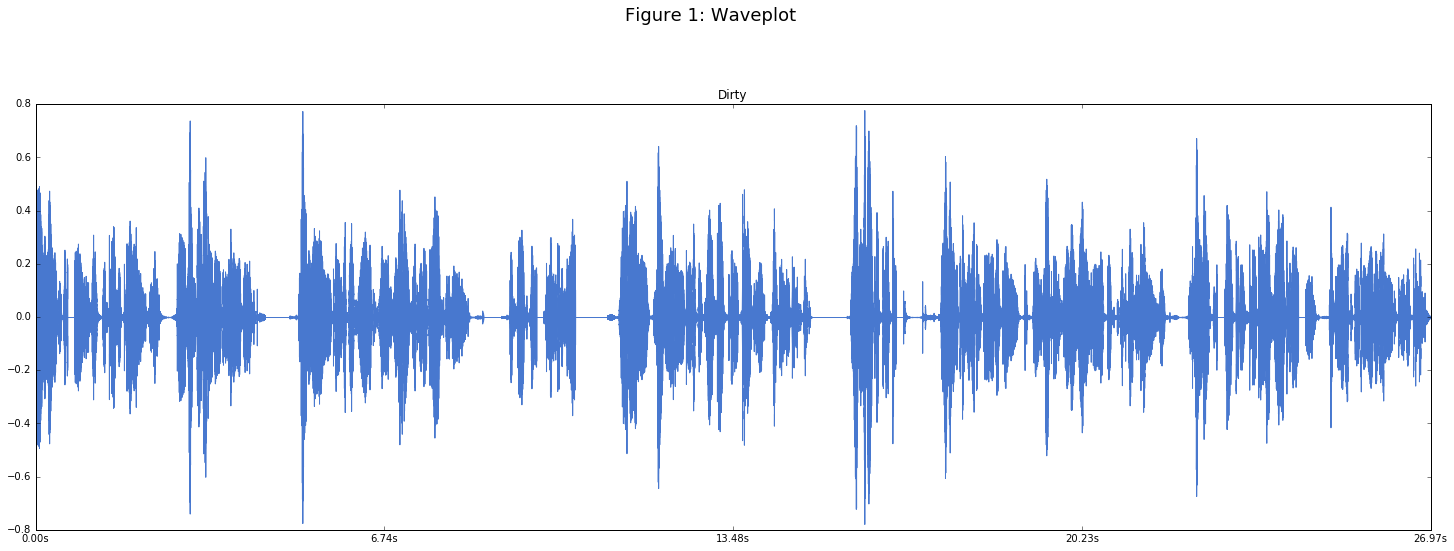

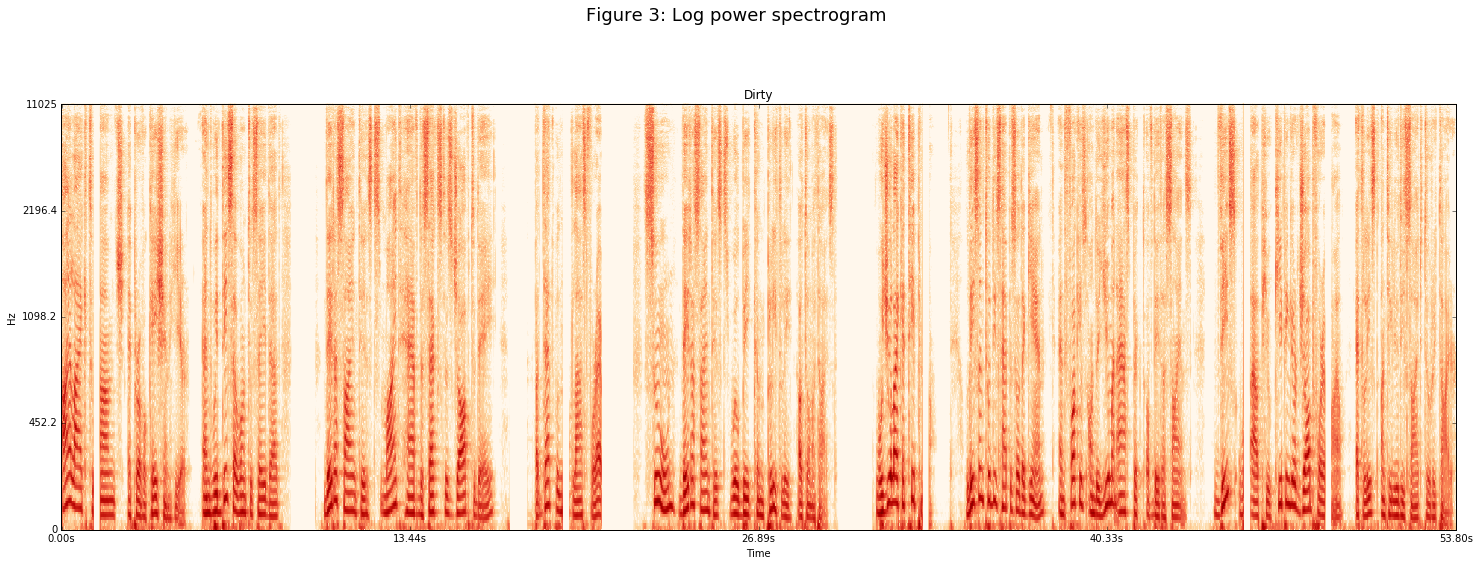

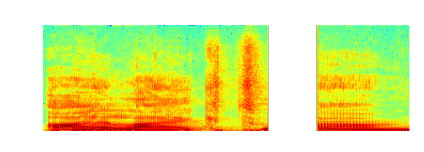

In [217]:
ut.plot_waves(sound_names,raw_sounds)
ut.plot_specgram(list(sound_names[3:]), list(raw_sounds[3:]))
ut.plot_log_power_specgram(sound_names,raw_sounds)

# traditional audio features 
mfccs, chroma, mel, contrast,tonnetz = ut.extract_feature('./data/jingle.wav')
ut.specgram_frombuffer(raw_sounds[0][0:44100], 6, 6, fname='/archive/buffer.png', show=True)

# found a good model to analyze the audio features above 
# and... good luck!